In [2]:
%matplotlib inline

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path  # Path style access for pandas
from tqdm import tqdm

In [4]:
import torch                    
import torchvision

In [10]:
data_dir = Path.cwd()/"hateful_memes"

img_tar_path = data_dir / "img"
train_path = data_dir / "train.jsonl"
dev_path = data_dir / "dev.jsonl"
test_path = data_dir / "test.jsonl"

In [11]:
train_samples_frame = pd.read_json(train_path, lines=True)
train_samples_frame.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


Balanced dataset?

In [12]:
train_samples_frame.label.value_counts()

0    5481
1    3019
Name: label, dtype: int64

In [30]:
n_train = len(train_samples_frame)

In [14]:
train_samples_frame.text.map(
    lambda text: len(text.split(" "))).describe()

count    8500.000000
mean       11.748706
std         6.877880
min         1.000000
25%         7.000000
50%        10.000000
75%        15.000000
max        70.000000
Name: text, dtype: float64

In [32]:
from PIL import Image


images = [
    Image.open(
        data_dir / train_samples_frame.loc[i, "img"]
    ).convert("RGB").size
    for i in range(n_train)
]

In [66]:
from scipy import stats

heights = list(list(zip(*images))[0])
widths = list(zip(*images))[1]

print(stats.describe(heights))
print(stats.describe(widths))

DescribeResult(nobs=8500, minmax=(94, 825), mean=597.6498823529412, variance=31608.07201434079, skewness=-0.28685862159965186, kurtosis=-0.6997084149353303)
DescribeResult(nobs=8500, minmax=(94, 823), mean=523.5962352941176, variance=27862.35513348975, skewness=0.6726864305978104, kurtosis=-1.0065602202608568)


In [142]:
train_samples_frame.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [90]:
img_sample = [
    Image.open(
        data_dir / train_samples_frame.loc[i, "img"]
    ).convert("RGB")
    for i in random.sample(range(0, n_train), 4)
]

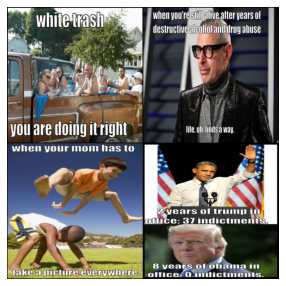

In [92]:
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(500, 500)),
        torchvision.transforms.ToTensor()
    ]
)

# convert the images and prepare for visualization.
tensor_img = torch.stack([image_transform(image) for image in img_sample])

grid = torchvision.utils.make_grid(tensor_img, nrow = 2)
# plot

plt.axis('off')
#plt.figure(figsize = [10, 10])
_ = plt.imshow(grid.permute(1,2, 0))

Baseline & VisualBERT with BareFace

In [116]:
bs_dir = Path.cwd()/"bs.csv"
vbf_dir = Path.cwd()/"vbf.csv"

In [120]:
bs_frame = pd.read_csv(bs_dir)
vbf_frame = pd.read_csv(vbf_dir)

bs_frame.head()

,Unnamed: 0,img_id,preds,labels
0,0,tensor(42059),"tensor([1.], device='cuda:0')","tensor(0., device='cuda:0')"
1,1,tensor(52804),"tensor([1.], device='cuda:0')","tensor(1., device='cuda:0')"
2,2,tensor(63529),"tensor([0.], device='cuda:0')","tensor(0., device='cuda:0')"
3,3,tensor(6328),"tensor([1.], device='cuda:0')","tensor(0., device='cuda:0')"
4,4,tensor(75926),"tensor([1.], device='cuda:0')","tensor(0., device='cuda:0')"


In [119]:
vbf_frame.head()

,Unnamed: 0,img_id,preds,labels
0,0,tensor(30865),"tensor([0.], device='cuda:0')","tensor(1., device='cuda:0')"
1,1,tensor(14907),"tensor([0.], device='cuda:0')","tensor(0., device='cuda:0')"
2,2,tensor(47305),"tensor([0.], device='cuda:0')","tensor(0., device='cuda:0')"
3,3,tensor(68705),"tensor([0.], device='cuda:0')","tensor(1., device='cuda:0')"
4,4,tensor(38150),"tensor([0.], device='cuda:0')","tensor(0., device='cuda:0')"


In [121]:
bs_frame['img_id'] = bs_frame['img_id'].str.extract('(\d+)', expand=False)
for i in ["preds", "labels"]:
    bs_frame[i] = bs_frame[i].str.extract('(\d+)', expand = False)
bs_frame.head()

,Unnamed: 0,img_id,preds,labels
0,0,42059,1,0
1,1,52804,1,1
2,2,63529,0,0
3,3,6328,1,0
4,4,75926,1,0


In [122]:
vbf_frame['img_id'] = vbf_frame['img_id'].str.extract('(\d+)', expand=False)
for i in ["preds", "labels"]:
    vbf_frame[i] = vbf_frame[i].str.extract('(\d+)', expand = False)
vbf_frame.head()

,Unnamed: 0,img_id,preds,labels
0,0,30865,0,1
1,1,14907,0,0
2,2,47305,0,0
3,3,68705,0,1
4,4,38150,0,0


In [123]:
bs_confusion = pd.crosstab(bs_frame["labels"], bs_frame["preds"], rownames = ["Actual"], colnames = ["Predicted"], normalize = "all")
bs_conf_pct = pd.crosstab(bs_frame["labels"], bs_frame["preds"], rownames = ["Actual"], colnames = ["Predicted"])
print(bs_confusion, bs_conf_pct)

Predicted      0      1
Actual                 
0          0.435  0.190
1          0.212  0.163 Predicted    0    1
Actual             
0          870  380
1          424  326


In [289]:
vb_confusion = pd.crosstab(vb_frame["labels"], vb_frame["preds"], rownames = ["Actual"], colnames = ["Predicted"], normalize = "all")
vb_conf_pct = pd.crosstab(vb_frame["labels"], vb_frame["preds"], rownames = ["Actual"], colnames = ["Predicted"])
print(vb_confusion, vb_conf_pct)

Predicted      0      1
Actual                 
0          0.472  0.153
1          0.242  0.133 Predicted    0    1
Actual             
0          944  306
1          484  266


In [289]:
vb_confusion = pd.crosstab(vb_frame["labels"], vb_frame["preds"], rownames = ["Actual"], colnames = ["Predicted"], normalize = "all")
vb_conf_pct = pd.crosstab(vb_frame["labels"], vb_frame["preds"], rownames = ["Actual"], colnames = ["Predicted"])
print(vb_confusion, vb_conf_pct)

Predicted      0      1
Actual                 
0          0.472  0.153
1          0.242  0.133 Predicted    0    1
Actual             
0          944  306
1          484  266


VisualBERT

In [105]:
vb_dir = Path.cwd()/"vb.csv"
vb_frame = pd.read_csv(vb_dir)

In [103]:
vb_frame.head()

,Unnamed: 0,img_id,preds,labels
0,0,tensor(79218),"tensor([0.], device='cuda:0')","tensor(0., device='cuda:0')"
1,1,tensor(89345),"tensor([0.], device='cuda:0')","tensor(0., device='cuda:0')"
2,2,tensor(56309),"tensor([0.], device='cuda:0')","tensor(0., device='cuda:0')"
3,3,tensor(14682),"tensor([0.], device='cuda:0')","tensor(0., device='cuda:0')"
4,4,tensor(49205),"tensor([0.], device='cuda:0')","tensor(1., device='cuda:0')"


In [106]:
vb_frame['img_id'] = vb_frame['img_id'].str.extract('(\d+)', expand=False)
for i in ["preds", "labels"]:
    vb_frame[i] = vb_frame[i].str.extract('(\d+)', expand = False)
vb_frame.head()

,Unnamed: 0,img_id,preds,labels
0,0,79218,0,0
1,1,89345,0,0
2,2,56309,0,0
3,3,14682,0,0
4,4,49205,0,1


In [113]:
vb_confusion = pd.crosstab(vb_frame["labels"], vb_frame["preds"], rownames = ["Actual"], colnames = ["Predicted"], normalize = "all")
print(vb_confusion)

Predicted      0      1
Actual                 
0          0.472  0.153
1          0.242  0.133


Examples

In [135]:
vb_misclassed = vb_frame.loc[~(vb_frame['preds'] == vb_frame["labels"])]
vb_correct = vb_frame.loc[(vb_frame['preds'] == vb_frame["labels"])]

In [127]:
vbf_misclassed = vbf_frame.loc[~(vbf_frame['preds'] == vbf_frame["labels"])]
vbf_correct = vbf_frame.loc[(vbf_frame['preds'] == vbf_frame["labels"])]

In [128]:
bs_misclassed = bs_frame.loc[~(bs_frame['preds'] == bs_frame["labels"])]
bs_correct = bs_frame.loc[(bs_frame['preds'] == bs_frame["labels"])]

All got wrong, or only VBF right, only need to change some variables below, so code below are reused a lot. 

In [290]:
misclassed = bs_correct.merge(vb_misclassed, left_on = "img_id", right_on = "img_id")\
                          .merge(vbf_misclassed, left_on = "img_id", right_on = "img_id")

In [291]:
misclassed.head(4)

,Unnamed: 0_x,img_id,preds_x,labels_x,Unnamed: 0_y,preds_y,labels_y,Unnamed: 0,preds,labels
0,42,74580,0,0,1040,1,0,1000,1,0
1,43,47026,1,1,559,0,1,1028,0,1
2,65,49865,0,0,1147,1,0,1698,1,0
3,86,62107,1,1,1670,0,1,284,0,1


In [269]:
misclassed = vbf_misclassed.merge(vb_correct, left_on = "img_id", right_on = "img_id")

In [230]:
mdf1 = misclassed.loc[((misclassed["preds_x"] == "0") & (misclassed["preds_y"] == "1") & (misclassed["preds"] == "1"))]

In [309]:
mdf1 = misclassed.loc[((misclassed["preds_x"] == "0"))]

In [292]:
len(misclassed)

128

In [322]:
mdf1.head(8)

,Unnamed: 0_x,img_id,preds_x,labels_x,Unnamed: 0_y,preds_y,labels_y,Unnamed: 0,preds,labels
0,42,74580,0,0,1040,1,0,1000,1,0
2,65,49865,0,0,1147,1,0,1698,1,0
14,298,98326,0,0,1794,1,0,1122,1,0
24,423,90276,0,0,1908,1,0,345,1,0
30,586,30971,0,0,250,1,0,1076,1,0
32,605,46390,0,0,524,1,0,1524,1,0
37,640,93167,0,0,229,1,0,615,1,0
74,1099,28493,0,0,1103,1,0,361,1,0


In [323]:
mis_img = ["74580", "28493", "30497", "62107"]
mis_img = [s + ".png" for s in mis_img]

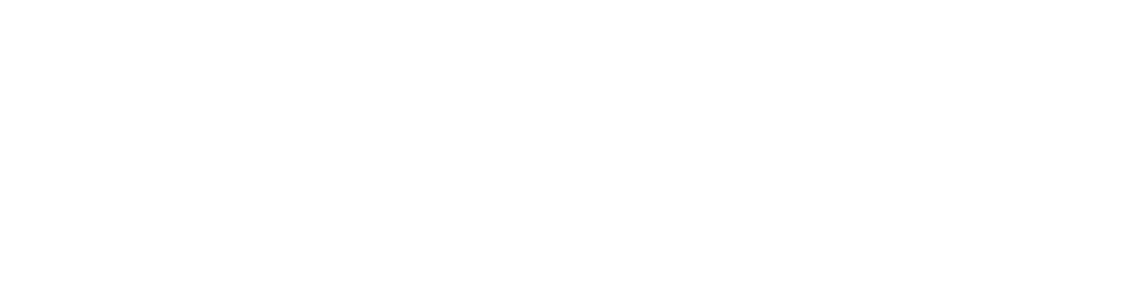

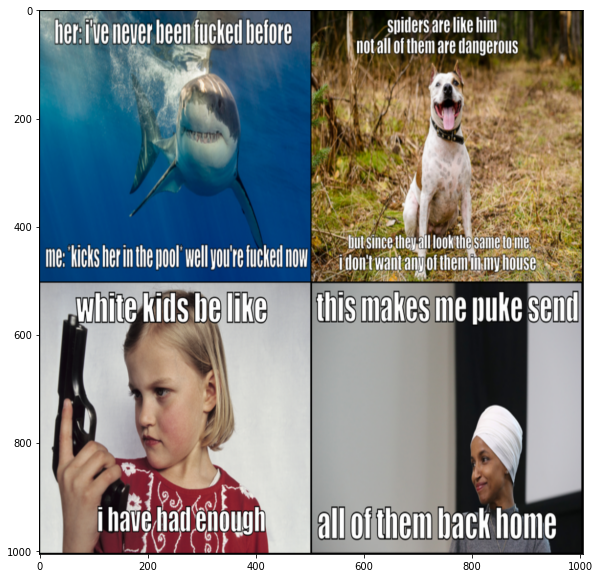

In [324]:
mis1 = [
    Image.open(
        data_dir/"img" / i
    ).convert("RGB")
    for i in mis_img
]

image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(500, 500)),
        torchvision.transforms.ToTensor()
    ]
)

# convert the images and prepare for visualization.
tensor_img = torch.stack([image_transform(image) for image in mis1])

grid = torchvision.utils.make_grid(tensor_img, nrow = 2)
# plot

plt.axis('off')
plt.figure(figsize = [10, 10])
_ = plt.imshow(grid.permute(1,2, 0))

Only model 3 right: